In [159]:
from striped.job import SinglePointStripedSession as Session, IPythonDisplay
from vega import VegaLite

import cloudpickle
import zlib

import uproot, uproot_methods
import awkward
import numpy as np

import fnal_column_analysis_tools
from fnal_column_analysis_tools.lookup_tools import extractor
from fnal_column_analysis_tools.lookup_tools import evaluator 
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray

In [160]:
run_all = True
datasets = ["ZZTo2L2Nu_13TeV_powheg_pythia8"]

In [161]:
extractor = fnal_column_analysis_tools.lookup_tools.extractor()
extractor.add_weight_sets(['* * lookup_tables/eleTrig.root','* * lookup_tables/muon_trig_Run2016BtoF.root',
                           '* * lookup_tables/EIDISO_WH_out.json',
                           '* * lookup_tables/Tight27AfterIDISO_out.json',
                           '* * lookup_tables/failingVeto_out.json', 
                           '* * lookup_tables/ElectronID_SFs_WP90.root',
                           '* * lookup_tables/ScaleFactor_etracker_80x.json', 
                           '* * lookup_tables/kfactor_24bins.root'])
extractor.finalize()

evaluator = extractor.make_evaluator()

pickle_evaluator = zlib.compress(cloudpickle.dumps(evaluator))

In [162]:
def parse_datasets(cfgfile):
    xsec_dict = {}
    sample_dict = {}
    with open(cfgfile) as f:
        for l in f:
            l = l.strip()
            if l.startswith('#'):
                continue
            pieces = l.split()
            if(l == ''):
                continue
            if len(pieces) < 3:
                print('Invalid input format:\n%s' % l)
                continue
            samp = pieces[0]
            sample_group = pieces[1]
            sample_dict[samp] = sample_group
            isData = not ('MC' in pieces[2])
            if not isData:
                if len(pieces) < 4:
                    printf('Cannot find cross section:\n%s' % l)
                    continue
                else:
                    try:
                        xsec = float(pieces[3])
                    except ValueError:
                        import numexpr
                        xsec = numexpr.evaluate(pieces[3]).item()
                    except:
                        printf('Trouble parsing xsec:\n%s' % l)
                        continue
                xsec_dict[samp] = xsec
        
    return xsec_dict, sample_dict

In [163]:
xsec_dict, sample_dict = parse_datasets('datasets_2016_minimal.txt')
print (xsec_dict)

{'DYJetsToNuNu_PtZ-100To250_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8': 164.46869999999998, 'WJetsToLNu_Pt-100To250_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8': 677.82, 'DYJetsToLL_Pt-50To100_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8': 374.68, 'DYJetsToNuNu_PtZ-50To100_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8': 668.9413199999999, 'DYJetsToNuNu_PtZ-650ToInf_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8': 0.07830000000000001, 'WJetsToLNu_Wpt-50To100_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8': 3298.37, 'WJetsToLNu_Pt-600ToInf_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8': 0.4602, 'WJetsToLNu_Pt-400To600_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8': 3.0563, 'DYJetsToLL_Pt-250To400_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8': 3.3247, 'DYJetsToLL_Pt-100To250_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8': 86.52, 'WJetsToLNu_Pt-250To400_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8': 24.083, 'DYJetsToNuNu_PtZ-250To400_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8': 6.2115, 'DYJetsToLL_Pt-400To650_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8':

In [164]:
#__worker_class__
import numpy as np
import zlib
import cloudpickle

import uproot, uproot_methods
import fnal_column_analysis_tools
from fnal_column_analysis_tools.lookup_tools import extractor
from fnal_column_analysis_tools.lookup_tools import evaluator 
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray

from collections import OrderedDict

import awkward
#import numba
#from collections import OrderedDict
#import matplotlib.pyplot as plt
##%matplotlib inline
#from fnal_column_analysis_tools import hist

class Worker(object):
    
    Columns = ["Photon.pt","Photon.eta","Photon.phi","Photon.mass","Jet.pt","Jet.eta","Jet.phi","Jet.mass","Jet.jetId",
              "Electron.pt","Electron.eta","Electron.phi","Electron.mass","Electron.pfRelIso03_all","Electron.dxy",
               "Electron.dz","Electron.cutBased","Electron.charge","Electron.deltaEtaSC",
               "Electron.mvaSpring16GP_WP80","Electron.mvaSpring16GP_WP90","Muon.pt","Muon.eta","Muon.phi","Muon.mass",
               "Muon.pfRelIso04_all","Muon.dxy","Muon.dz","Muon.charge","Muon.tightId",
               "nElectron","nMuon","nJet","nPhoton","nGenPart","nTau","nAK15Puppi",
               "MET_pt","MET_phi",
               "GenPart.pt","GenPart.eta","GenPart.phi",
               "GenPart.mass","GenPart.pdgId","GenPart.status","GenPart.statusFlags","GenPart.genPartIdxMother",
               "Tau.pt","Tau.eta","Tau.phi","Tau.mass","Tau.idDecayMode","Tau.idMVAnew",
               "AK15Puppi.pt","AK15Puppi.eta","AK15Puppi.phi","AK15Puppi.mass","AK15Puppi.jetId"]
    
    
    def run(self, events, job, db):
        dtype = job["dtype"]
        hists = job["hists"]
        dataset = job["dataset"]
                
        photon_columns   = {'pt':events.Photon.pt,'eta':events.Photon.eta,'phi':events.Photon.phi,
                             'mass':events.Photon.mass}
        
        jet_columns      = {'pt':events.Jet.pt,'eta':events.Jet.eta,'phi':events.Jet.phi,
                            'mass':events.Jet.mass,'id':events.Jet.jetId}

        fat_jet_columns = {'pt':events.AK15Puppi.pt,'eta':events.AK15Puppi.eta,'phi':events.AK15Puppi.phi,
                           'mass':events.AK15Puppi.mass,'jetId':events.AK15Puppi.jetId}
        
        electron_columns = {'pt':events.Electron.pt,'eta':events.Electron.eta,'phi':events.Electron.phi,
                            'mass':events.Electron.mass,
                            'iso':events.Electron.pfRelIso03_all,'dxy':events.Electron.dxy,
                            'dz':events.Electron.dz, 'cid':events.Electron.cutBased,
                            'charge':events.Electron.charge,
                            'deltaEtaSC':events.Electron.deltaEtaSC, 
                            'mva_WP80':events.Electron.mvaSpring16GP_WP80,
                          #  'cutBased_HLTPreSel':events.Electron.cutBased_HLTPreSel,
                            'mva_WP90':events.Electron.mvaSpring16GP_WP90}
        
        muon_columns     = {'pt':events.Muon.pt,'eta':events.Muon.eta,'phi':events.Muon.phi,
                             'mass':events.Muon.mass,'iso':events.Muon.pfRelIso04_all,
                             'dxy':events.Muon.dxy,'dz':events.Muon.dz,'charge':events.Muon.charge,
                             'cid':events.Muon.tightId}
            
                                 
        tau_columns      = {'pt':events.Tau.pt,'eta':events.Tau.eta,'phi':events.Tau.phi,
                            'mass':events.Tau.mass, 'decayMode':events.Tau.idDecayMode, 
                            'id':events.Tau.idMVAnew}
        
  #     if 'mc' in dtype:
  #          electron_columns.update({'pdgId':events.Electron.pdgId}) 
            
  #          muon_columns.update({'pdgId':events.Muon.pdgId})
                         
        gen_columns      = {'pt':events.GenPart.pt,'eta':events.GenPart.eta,'phi':events.GenPart.phi,
                            'mass':events.GenPart.mass,
                            'id':events.GenPart.pdgId,'status':events.GenPart.status,
                            'statusFlags':events.GenPart.statusFlags,
                            'mIdx':events.GenPart.genPartIdxMother}
          
        eval_pickle = job["evaluator"]
        eval_pickle = zlib.decompress(eval_pickle)
        evaluator = cloudpickle.loads(eval_pickle)
           
       # triggers  = {'SingleEle':np.prod([arrays[val] for val in singleele_trigger_columns],axis=0)}
    
        #job.message(awkward.__version__)
    
        electrons = JaggedCandidateArray.candidatesfromcounts(events.nElectron,
                **{key:val for key,val in electron_columns.items()})
        muons     = JaggedCandidateArray.candidatesfromcounts(events.nMuon, 
                **{key:val for key,val in muon_columns.items()})             
        photons   = JaggedCandidateArray.candidatesfromcounts(events.nPhoton, 
               **{key:val for key,val in photon_columns.items()})
        jets      = JaggedCandidateArray.candidatesfromcounts(events.nJet, 
               **{key:val for key,val in jet_columns.items()})
        fat_jets = JaggedCandidateArray.candidatesfromcounts(events.nAK15Puppi,
               **{key:val for key,val in fat_jet_columns.items()})
        genPart   = JaggedCandidateArray.candidatesfromcounts(events.nGenPart, 
               **{key:val for key,val in gen_columns.items()})
        taus      = JaggedCandidateArray.candidatesfromcounts(events.nTau, 
               **{key:val for key,val in tau_columns.items()})                                                         

        met_vec = uproot_methods.TLorentzVectorArray.from_ptetaphi(events.MET_pt,0,events.MET_phi,0)
        #jagged_met = JaggedCandidateArray.candidatesfromcounts(np.ones(events.MET_pt),p4=met_vec)
        
        # end initialize
           
             # physical objects selection
        loose_electron_selection = (electrons.pt>7)&(abs(electrons.eta)<2.4)&((electrons.cid&2)!=0)&(electrons.mva_WP80)  
        #(electrons.cid&2)!=0 for loose selection 
        tight_electron_selection = (electrons.pt>40)&(abs(electrons.eta)<2.4)&((electrons.cid&4)!=0)&(electrons.mva_WP80) #(electrons.cid&4)!=0 for tight selection
        loose_muon_selection =  (muons.pt>5)&(abs(muons.eta)<2.4)   # "isLooseMuon" is already added in muon object
        tight_muon_selection =  (muons.pt>10)&(abs(muons.eta)<2.4)&(muons.cid)   # muons.cid for tight muon selection
        loose_photon_selection = (photons.pt>15)&(abs(photons.eta)<2.5)
        #&((photons.cid&1)!=0)  #(photons.cid&1)!=0 for loose selection 
        tight_photon_selection = (photons.pt>175)&(abs(photons.eta)<2.5)#&((photons.cid&3)!=0) #(photons.cid&3)!=0 for tight selection 
        tau_selection = (taus.pt>18)&(abs(taus.eta)<2.3)&(taus.decayMode)&((taus.id&2)!=0)
        fat_jet_selection = (fat_jets.pt > 200)&(abs(fat_jets.eta)<2.4)&(fat_jets.jetId > 0)
        jet_selection = (jets.pt>25)&(abs(jets.eta)<4.5)&((jets.id&2)!=0)

        loose_electrons = electrons[loose_electron_selection]
        tight_electrons = electrons[tight_electron_selection]
        loose_muons = muons[loose_muon_selection]
        tight_muons = muons[tight_muon_selection]
        loose_photons = photons[loose_photon_selection]
        tight_photons = photons[tight_photon_selection]
        selected_taus = taus[tau_selection]
        selected_fat_jets = fat_jets[fat_jet_selection]
        selected_jets = jets[jet_selection]
        jet_combinations = selected_jets.p4.cross(loose_electrons.p4, nested=True)
        mask = (jet_combinations.i0.delta_r(jet_combinations.i1) < 0.3 ).any()
        e_clean_jets = selected_jets[~mask]

        jet_combinations = e_clean_jets.p4.cross(loose_muons.p4, nested=True)
        mask = (jet_combinations.i0.delta_r(jet_combinations.i1) < 0.3).any()
        clean_jets = e_clean_jets[~mask]

        # once merge is done
        # mask = selected_jets.p4.match(clean_electrons.p4, 0.3)
        # clean_jets = selected_jets[~mask]
            # end cleaning

        tight_electron_selection = ((loose_electrons.pt > 30)&#(loose_electrons.id)&
                                  (loose_electrons.mva_WP80)&(loose_electrons.iso < 0.06))

        tight_electrons = loose_electrons[tight_electron_selection]
        tight_electrons_1L =tight_electrons
        
        clean_electrons = loose_electrons
        clean_muons = loose_muons
        clean_fat_jets = selected_fat_jets
        
                #Get recoils
            #ARH - this could be improved by defining a single recoil object regardless of region. 
        pfUA = self.get_recoil(met_vec,loose_photons)
        pfUWe = self.get_recoil(met_vec,clean_electrons)
        pfUWm = self.get_recoil(met_vec,clean_muons)
        
        dPhiMet = abs(jets.p4.delta_phi(met_vec)).min()
        dPhipfUWm = abs(jets.p4.delta_phi(pfUWm)).min()
        dPhipfUWe = abs(jets.p4.delta_phi(pfUWe)).min()
        dPhipfUA = abs(jets.p4.delta_phi(pfUA)).min()
            #End of recoils            

            #signal and control region selections
        preselection = (selected_taus.counts==0)&(clean_fat_jets.counts>0)
        
        
                #No triggers are applied yet!
        
        selections = OrderedDict()
        selections['signal'] = preselection&(clean_muons.counts==0)&(clean_electrons.counts==0)&(loose_photons.counts==0)&(met_vec.pt>200)&(dPhiMet > 0.8)

        #Need to calculate mt and apply cuts of mT<160'. Need one tight muon.
        selections['mn'] = preselection&(clean_muons.counts==1)&(clean_electrons.counts==0)&(loose_photons.counts==0)&(pfUWm.pt>200)&(dPhipfUWm > 0.8)&(met_vec.pt>50)
        #Need to calculate mt and apply cuts of mT<160'. Need one tight electron
        selections['en'] = preselection&(clean_muons.counts==0)&(clean_electrons.counts==1)&(loose_photons.counts==0)&(pfUWe.pt>200)&(dPhipfUWe > 0.8)

        #Need at least one tight muon, 60<diLepMass && diLepMass<120
        selections['zmm'] = preselection&(clean_muons.counts==2)&(clean_electrons.counts==0)&(loose_photons.counts==0)&(pfUWm.pt>200)&(dPhipfUWm > 0.8)
        #Need at least one tight electron, 60<diLepMass && diLepMass<120
        selections['zee'] = preselection&(clean_muons.counts==0)&(clean_electrons.counts==2)&(loose_photons.counts==0)&(pfUWe.pt>200)&(dPhipfUWe > 0.8)
        #Need loosePho1IsTight
        selections['pho'] = preselection&(clean_muons.counts==0)&(clean_electrons.counts==0)&(loose_photons.counts==1)&(pfUA.pt>200)&(dPhipfUA > 0.8)
        
        #genPart_1LSfe_selection = (abs(genPart.id==11))&(genPart.statusFlags&1 !=0)&(genPart.statusFlags&8192 != 0)

        #gen_prompt_electrons = genPart[genPart_1LSfe_selection]
        #gen_electrons_combinations = tight_electrons.p4.cross(gen_prompt_electrons.p4,nested=True)
        #gen_electrons_mask = (gen_electrons_combinations.i0.delta_r(gen_electrons_combinations.i1)<0.4).any()

        #_1L_electrons = tight_electrons[gen_electrons_mask]
        #weight, weight_up, weight_down = self.calculateEleWeights(evaluator, _1L_electrons)

        #dielectron_selection = (tight_electrons.counts>0)&(clean_jets.counts==0)#&(triggers["SingleEle"]==1)#&(loose_photons.counts==0)

        #dielectrons = loose_electrons[dielectron_selection].distincts()
        #dielectron_mass = dielectrons.mass
        #e_weight = weight[dielectron_selection][dielectrons.counts>0]
        #dielectron_mass = dielectron_mass[dielectron_mass.counts>0][:,0]
        
        for region in selections:
            hists['recoil'].fill(dataset=dataset,region=region,recoil=met_vec[selections[region]].pt.flatten()) 
   #        hists['dPhi']
            hists['fjPt'].fill(dataset=dataset,   region=region, fjPt=clean_fat_jets[selections[region]].pt.flatten())
            hists['fjEta'].fill(dataset=dataset,  region=region, fjEta=clean_fat_jets[selections[region]].eta.flatten())
            hists['phoPt'].fill(dataset=dataset,  region=region, phoPt=loose_photons[selections[region]].pt.flatten())
            hists['phoEta'].fill(dataset=dataset, region=region, phoEta=loose_photons[selections[region]].eta.flatten())
            hists['elePt'].fill(dataset=dataset,  region=region, elePt=clean_electrons[selections[region]].pt.flatten())
            hists['eleEta'].fill(dataset=dataset, region=region, eleEta=clean_electrons[selections[region]].eta.flatten())
            hists['muPt'].fill(dataset=dataset,   region=region, muPt=clean_muons[selections[region]].pt.flatten())
            hists['muEta'].fill(dataset=dataset,  region=region, muEta=clean_muons[selections[region]].eta.flatten())
            #hists[''].fill(dataset=dataset,region=region,=.flatten())

        job.send(hists=hists)

        
    def calculateEleWeights(self, evaluator, electrons):
        sfReco = np.ones(electrons.size)
        sfReco_up = np.ones(electrons.size)
        sfReco_down = np.ones(electrons.size)
        sfTrig = np.ones(electrons.size)
        sfTrig_up = np.ones(electrons.size)
        sfTrig_down = np.ones(electrons.size)
        sfIdIso = np.ones(electrons.size)
        sfIdIso_up = np.ones(electrons.size)
        sfIdIso_down = np.ones(electrons.size)
        sfId = np.ones(electrons.size)
        sfId_up = np.ones(electrons.size)
        sfId_down = np.ones(electrons.size)

        sfReco_value  = 'ScaleFactor_tracker_80x/eta_pt_ratio_value'
        sfReco_error  = 'ScaleFactor_tracker_80x/eta_pt_ratio_error'
        sfIdIso_value = 'EIDISO_WH/eta_pt_ratio_value'
        sfIdIso_error = 'EIDISO_WH/eta_pt_ratio_error'
        sfTrig_value  = 'Tight27AfterIDISO/eta_pt_ratio_value'
        sfTrig_error  = 'Tight27AfterIDISO/eta_pt_ratio_error'

        c =electrons.counts
        etaSC = electrons.eta+electrons.deltaEtaSC
        pt = electrons.pt
        sfReco[c>0] = evaluator[sfReco_value](etaSC,pt)[c>0][:,0]
        sfReco_up[c>0] = sfReco[c>0] + evaluator[sfReco_error](etaSC,pt)[c>0][:,0]
        sfReco_down[c>0] = sfReco[c>0] - evaluator[sfReco_error](etaSC,pt)[c>0][:,0]
        sfReco_up[c>0][electrons[c>0].pt[:,0] >80] = sfReco_up[c>0][electrons[c>0].pt[:,0] >80] + 0.01
        sfReco_down[c>0][electrons[c>0].pt[:,0] >80] = sfReco_down[c>0][electrons[c>0].pt[:,0] >80] - 0.01

        sfIdIso[c >0] = evaluator[sfIdIso_value](etaSC,pt)[c>0][:,0]
        sfIdIso_up[c>0] = sfIdIso[c > 0] + evaluator[sfIdIso_error](etaSC,pt)[c>0][:,0]
        sfIdIso_down[c>0] =sfIdIso[c > 0] - evaluator[sfIdIso_error](etaSC,pt)[c>0][:,0]

        sfTrig[c>0] = evaluator[sfTrig_value](etaSC,pt)[c>0][:,0]
        sfTrig_up[c>0] = sfTrig[c>0] + evaluator[sfTrig_error](etaSC, pt)[c>0][:,0]
        sfTrig_down[c>0] =sfTrig[c>0] - evaluator[sfTrig_error](etaSC,pt)[c>0][:,0]

        weight = sfTrig*sfIdIso*sfId*sfReco
        weight_up = sfTrig_up*sfIdIso_up*sfId*sfReco_up
        weight_down = sfTrig_down*sfIdIso_down*sfId*sfReco_down

        return weight, weight_up, weight_down
    
    def get_recoil(self,met,add_objects):
        #ARH: This worked until an update in awkward. Have to wait for a new release then it should work again
        #highest_pt = add_objects.p4[add_objects.pt.argmax()]
        
        #recoil = met.zeros_like()
        #recoil = recoil.cross(highest_pt)
        #recoil = (recoil.i0+recoil.i1+met).p4
        
        #recoil = met
        #recoil = add_objects.pt.sum() + met.pt
        recoil = add_objects.p4.sum() + met
        return recoil

        

In [165]:
import fnal_column_analysis_tools.hist as hist

dataset = hist.Cat("dataset", "DAS name")
region =  hist.Cat("region", "Control or Signal region")

hists = OrderedDict()
hists['recoil'] = hist.Hist("Events", dataset, region, hist.Bin("recoil", "Recoil (GeV)", [0.,100,200,300,400,600,1000,2000]))
hists['dPhi']   = hist.Hist("Events", dataset, region, hist.Bin("dPhi","Min dPhi(recoil,jets)",16,0,3.2))
hists['fjEta']  = hist.Hist("Events", dataset, region, hist.Bin("fjEta","Fat Jet Eta",50,-2.5,2.5))
hists['fjPt']   = hist.Hist("Events", dataset, region, hist.Bin("fjPt","Fat Jet Pt (GeV)",20,200,800))
hists['phoPt']  = hist.Hist("Events", dataset, region, hist.Bin("phoPt","Photon Pt (GeV)",20,200,800))
hists['phoEta'] = hist.Hist("Events", dataset, region, hist.Bin("phoEta","Photon Eta",50,-2.5,2.5))
hists['elePt']  = hist.Hist("Events", dataset, region, hist.Bin("elePt","Electron Pt (GeV)",20,200,800))
hists['eleEta'] = hist.Hist("Events", dataset, region, hist.Bin("eleEta","Electron Eta",50,-2.5,2.5))
hists['muPt']   = hist.Hist("Events", dataset, region, hist.Bin("muPt","Muon Pt (GeV)",20,200,800))
hists['muEta']  = hist.Hist("Events", dataset, region, hist.Bin("muEta","Muon Eta",50,-2.5,2.5))
#hists['']= hist.Hist("Events", dataset, region, hist.Bin())



In [166]:
from __future__ import print_function
import threading

class MyHistCollectorCallback(object):
    def __init__(self, hists, redraw_fcn, update=2e5):
        """
            hists: a dictionary of histograms that will be kept by reference and updated
                        with the partial results of the striped session
            redraw_fcn: a callable method that will redraw whatever histograms you want
                        to display in real time as the histograms are updated.  It must
                        return a list of figures
            update: the redraw function will only be called after this many events have
                        been collected from the striped workers
        """
        self._hists = hists
        self._redraw = redraw_fcn
        self._update = update
        self._seen = 0
        self._lock = threading.Lock()

    @property
    def lock(self):
        return self._lock

    def on_streams_update(self, nevents, data):
        """
            This method is called by striped
        """
        if "hists" in data:
            for key in data["hists"]:
                for key2 in key:
                    self._hists[key2] += key[key2]
        self._seen += nevents
        if self._seen > self._update:
            self._seen = 0
            self.update_histograms()
    
    def update_histograms(self):
        figs = self._redraw()
        for fig in figs:
            fig.canvas.draw()
    
    def on_exception(self, wid, info):
        print("Worker exception:")
        print(info)

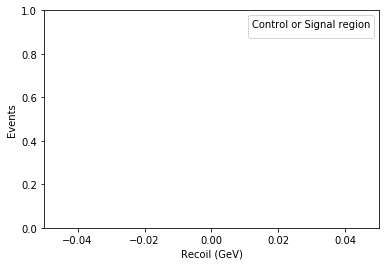

In [167]:
session = Session("/Users/ahall/striped.yaml")


from fnal_column_analysis_tools.hist import plot

class PlotDrawer(object):    
    def __call__(self):
        figs = []
        return figs
class PlotDrawer(object):    
    def __call__(self):
        figs = []
        figs.append(self.draw_recoil())
        return figs
    
    def draw_recoil(self):
        figin = getattr(self, 'massfig', None)
        hist2d = hists['recoil'].project('dataset')
        fig, ax, temp= plot.plot1d(hist2d,overlay='region',ax=figin,fill_opts={})
        self.massfig = ax
        return fig
        
draw = PlotDrawer()
callback = MyHistCollectorCallback(hists, draw, update=1e6)
# This cell must stay separated from the update loop
# https://github.com/matplotlib/jupyter-matplotlib/issues/17
figs = draw()

In [168]:
if run_all:
    datasets=sample_dict
for dataset_name in datasets:
    if ("madgraph"in dataset_name) or ("pythia") in dataset_name:
        dtype = 'mc'
    else:
        dtype = 'data'
    job = session.createJob(dataset_name, 
        callbacks=callback,
        user_params = {"dataset":dataset_name,"dtype":dtype, "evaluator":pickle_evaluator, "hists":hists}
    )
    job.run()
    runtime = job.TFinish - job.TStart
    #print (dataset_name)
    nevents = job.EventsProcessed
    print ("%-70s %7.3f M events, %7.3f M events/sec" % (dataset_name, float(nevents)/1000000, nevents/runtime/1000000))
figs = draw()

Job 2110066: worker #135 failed to load frame 810
Job 2110066: worker #152 failed to load frame 912
Job 2110066: worker #4 failed to load frame 24
Job 2110066: worker #108 failed to load frame 648
Job 2110066: worker #232 failed to load frame 1347
Job 2110066: worker #174 failed to load frame 1044
Job 2110066: worker #183 failed to load frame 1098
Job 2110066: worker #24 failed to load frame 144
Job 2110066: worker #2 failed to load frame 12
Job 2110066: worker #262 failed to load frame 1497
Job 2110066: worker #216 failed to load frame 1267
Job 2110066: worker #273 failed to load frame 1552
Job 2110066: worker #35 failed to load frame 210
Job 2110066: worker #115 failed to load frame 690
Job 2110066: worker #253 failed to load frame 1452
Job 2110066: worker #50 failed to load frame 300
Job 2110066: worker #244 failed to load frame 1407
Job 2110066: worker #243 failed to load frame 1402
Job 2110066: worker #13 failed to load frame 78
Job 2110066: worker #254 failed to load frame 1457
J

Job 2110066: worker #266 failed to load frame 1518
Job 2110066: worker #132 failed to load frame 793
Job 2110066: worker #70 failed to load frame 420
Job 2110066: worker #39 failed to load frame 235
Job 2110066: worker #48 failed to load frame 289
Job 2110066: worker #237 failed to load frame 1372
Job 2110066: worker #245 failed to load frame 1412
Job 2110066: worker #144 failed to load frame 865
Job 2110066: worker #15 failed to load frame 90
Job 2110066: worker #76 failed to load frame 457
Job 2110066: worker #254 failed to load frame 1459
Job 2110066: worker #181 failed to load frame 1086
Job 2110066: worker #14 failed to load frame 84
Job 2110066: worker #9 failed to load frame 55
Job 2110066: worker #271 failed to load frame 1544
Job 2110066: worker #157 failed to load frame 943
Job 2110066: worker #8 failed to load frame 50
Job 2110066: worker #58 failed to load frame 348
Job 2110066: worker #34 failed to load frame 205
Job 2110066: worker #82 failed to load frame 492
Job 2110066

Job 2110066: worker #211 failed to load frame 1246
Job 2110066: worker #17 failed to load frame 105
Job 2110066: worker #272 failed to load frame 1548
Job 2110066: worker #123 failed to load frame 741
Job 2110066: worker #39 failed to load frame 236
Job 2110066: worker #126 failed to load frame 757
Job 2110066: worker #114 failed to load frame 684
Job 2110066: worker #104 failed to load frame 626
Job 2110066: worker #182 failed to load frame 1094
Job 2110066: worker #99 failed to load frame 596
Job 2110066: worker #177 failed to load frame 1062
Job 2110066: worker #208 failed to load frame 1228
Job 2110066: worker #167 failed to load frame 1004
Job 2110066: worker #57 failed to load frame 345
Job 2110066: worker #164 failed to load frame 984
Job 2110066: worker #63 failed to load frame 378
Job 2110066: worker #50 failed to load frame 303
Job 2110066: worker #35 failed to load frame 212
Job 2110066: worker #161 failed to load frame 968
Job 2110066: worker #256 failed to load frame 1468


Job 2110066: worker #122 failed to load frame 733
Job 2110066: worker #98 failed to load frame 592
Job 2110066: worker #174 failed to load frame 1047
Job 2110066: worker #210 failed to load frame 1239
Job 2110066: worker #73 failed to load frame 440
Job 2110066: worker #149 failed to load frame 897
Job 2110066: worker #119 failed to load frame 715
Job 2110066: worker #243 failed to load frame 1405
Job 2110066: worker #261 failed to load frame 1493
Job 2110066: worker #200 failed to load frame 1188
Job 2110066: worker #257 failed to load frame 1475
Job 2110066: worker #22 failed to load frame 133
Job 2110066: worker #160 failed to load frame 962
Job 2110066: worker #232 failed to load frame 1350
Job 2110066: worker #251 failed to load frame 1444
Job 2110066: worker #76 failed to load frame 458
Job 2110066: worker #185 failed to load frame 1112
Job 2110066: worker #241 failed to load frame 1393
Job 2110066: worker #33 failed to load frame 200
Job 2110066: worker #270 failed to load frame

Job 2110066: worker #28 failed to load frame 171
Job 2110066: worker #156 failed to load frame 938
Job 2110066: worker #218 failed to load frame 1279
Job 2110066: worker #132 failed to load frame 795
Job 2110066: worker #236 failed to load frame 1371
Job 2110066: worker #33 failed to load frame 202
Job 2110066: worker #175 failed to load frame 1053
Job 2110066: worker #74 failed to load frame 448
Job 2110066: worker #150 failed to load frame 901
Job 2110066: worker #68 failed to load frame 411
Job 2110066: worker #164 failed to load frame 986
Job 2110066: worker #65 failed to load frame 392
Job 2110066: worker #212 failed to load frame 1248
Job 2110066: worker #229 failed to load frame 1334
Job 2110066: worker #71 failed to load frame 430
Job 2110066: worker #273 failed to load frame 1554
Job 2110066: worker #45 failed to load frame 273
Job 2110066: worker #136 failed to load frame 819
Job 2110066: worker #123 failed to load frame 743
Job 2110066: worker #188 failed to load frame 1128


Traceback (most recent call last):
  File "/Users/ahall/.local/lib/python2.7/site-packages/striped-1.12.2-py2.7-macosx-10.9-x86_64.egg/striped/common/DataExchange.py", line 247, in recv
    try:    msg = DXMessage.fromBufferedSocket(self)
  File "/Users/ahall/.local/lib/python2.7/site-packages/striped-1.12.2-py2.7-macosx-10.9-x86_64.egg/striped/common/DataExchange.py", line 110, in fromBufferedSocket
    sync = sock.readn(3)
  File "/Users/ahall/.local/lib/python2.7/site-packages/striped-1.12.2-py2.7-macosx-10.9-x86_64.egg/striped/common/DataExchange.py", line 213, in readn
    word = self.Sock.recv(100000)
error: [Errno 4] Interrupted system call



NameError: global name 'nevents' is not defined

In [ ]:
hist2d = hists['recoil'].project('region')

fig, ax, _ = plot.plot1d(hist2d,overlay='dataset',fill_opts={})  
lumi = 100
ax.text(1., 1., r"%.2f fb$^{-1}$ (13 TeV)" % (lumi), fontsize=16, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
ax.set_yscale('log')
ax.autoscale(axis='y', tight=False)
ax.set_ylim(1, None)

In [ ]:
hist2d = hists['phoPt'].project('region','pho')

fig, ax, _ = plot.plot1d(hist2d,overlay='dataset',fill_opts={})  
lumi = 100
ax.text(1., 1., r"%.2f fb$^{-1}$ (13 TeV)" % (lumi), fontsize=16, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
ax.set_yscale('log')
ax.autoscale(axis='y', tight=False)
ax.set_ylim(1, None)